In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
from joblib import dump, load

In [ ]:
# Config the variable so the following set up is easier
CSV_PATH  = "2_processed_data/labelled_dataset_revised.csv"
TEXT_COL  = "sentence"
LABEL_COL = "revised_argument_type"

VALID_LABELS = ['C', 'G', 'W/Q', 'OTH']

# Output folders/files
OUT_DIR = "3_model/svm"
os.makedirs(OUT_DIR, exist_ok=True)
PIPELINE_PATH = os.path.join(OUT_DIR, "svm_tfidf_pipeline.joblib")
LABELMAP_PATH = os.path.join(OUT_DIR, "label_mapping.json")

In [ ]:
# Load and data preparation
df = pd.read_csv(CSV_PATH, encoding="latin1")
df = df[[TEXT_COL, LABEL_COL]].dropna()

if VALID_LABELS:
    df = df[df[LABEL_COL].isin(VALID_LABELS)].copy()

texts = df[TEXT_COL].astype(str).tolist()
labels_raw = df[LABEL_COL].astype(str).tolist()

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels_raw)
id2label = {i: lbl for i, lbl in enumerate(le.classes_)}
label2id = {lbl: i for i, lbl in id2label.items()}

# Split
X_train, X_val, y_train, y_val = train_test_split(
    texts, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Build pipeline (TF-IDF + LinearSVC (calibrated))
base_svc = LinearSVC(C=1.0, class_weight="balanced", random_state=42)
clf = CalibratedClassifierCV(base_estimator=base_svc, method="sigmoid", cv=3)

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        analyzer="word",
        ngram_range=(1, 2),
        max_features=30000,
        min_df=2
    )),
    ("clf", clf),
])

In [ ]:
# Train
pipeline.fit(X_train, y_train)

Training...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warn

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=30000, min_df=2,
                                 ngram_range=(1, 2), strip_accents='unicode')),
                ('clf',
                 CalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                                 random_state=42),
                                        cv=3))])


=== Classification Report ===
              precision    recall  f1-score   support

           C       0.86      0.73      0.79      3388
           G       0.83      0.82      0.82      5736
         OTH       0.71      0.56      0.63      2753
         W/Q       0.82      0.92      0.87      9830

    accuracy                           0.82     21707
   macro avg       0.80      0.76      0.78     21707
weighted avg       0.81      0.82      0.81     21707

Confusion Matrix:
 [[2463  210  184  531]
 [  85 4713  185  753]
 [ 173  377 1538  665]
 [ 158  396  261 9015]]


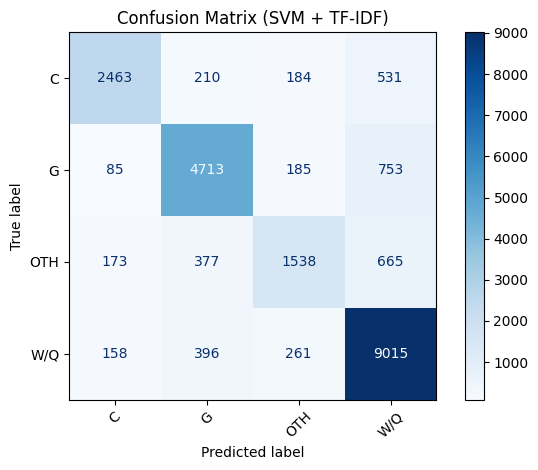


=== ROC AUCs ===
C: AUC = 0.9638
G: AUC = 0.9623
OTH: AUC = 0.9193
W/Q: AUC = 0.9568
Micro-average AUC: 0.9596
Macro-average AUC: 0.9505


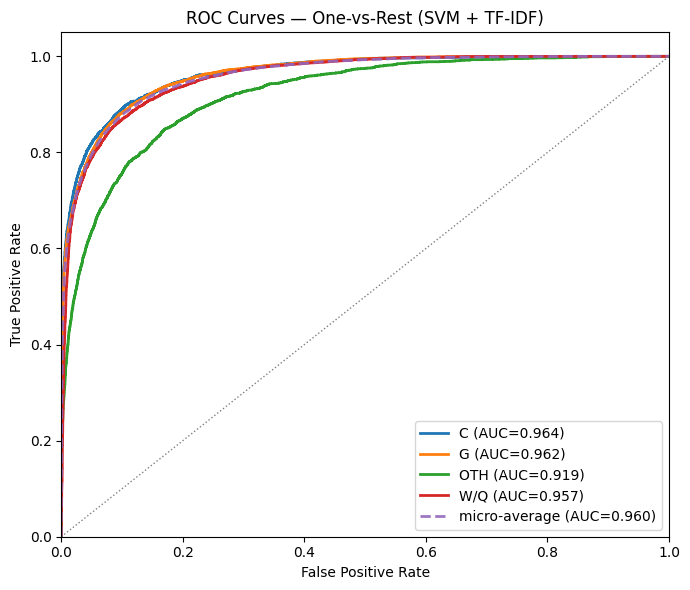

In [ ]:
# Evaluate
# Probabilities for ROC/AUC
if hasattr(pipeline.named_steps["clf"], "predict_proba"):
    probs_all = pipeline.predict_proba(X_val)  # shape (n_samples, n_classes)
else:
    # Fallback: use decision_function and softmax to approximate probabilities
    scores = pipeline.decision_function(X_val)
    # Ensure 2D
    if scores.ndim == 1:
        scores = np.vstack([-scores, scores]).T
    exp = np.exp(scores - scores.max(axis=1, keepdims=True))
    probs_all = exp / exp.sum(axis=1, keepdims=True)

# Hard predictions for report + confusion matrix
y_pred = probs_all.argmax(axis=1)

print("\n=== Classification Report ===")
all_labels = list(range(len(le.classes_)))
target_names = [id2label[i] for i in all_labels]
print(classification_report(
    y_val, y_pred,
    labels=all_labels,
    target_names=target_names,
    zero_division=0
))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred, labels=all_labels)
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (SVM + TF-IDF)")
plt.tight_layout()
plt.show()

# ROC / AUC (one-vs-rest)
Y_bin = label_binarize(y_val, classes=all_labels)  # (n_samples, n_classes)
fprs, tprs, aucs = {}, {}, {}
for i, cls_id in enumerate(all_labels):
    # skip if class absent in this split
    if Y_bin[:, i].sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(Y_bin[:, i], probs_all[:, i])
    fprs[cls_id], tprs[cls_id] = fpr, tpr
    aucs[cls_id] = auc(fpr, tpr)

# micro / macro AUC
fpr_micro, tpr_micro, _ = roc_curve(Y_bin.ravel(), probs_all.ravel())
auc_micro = auc(fpr_micro, tpr_micro)
auc_macro = float(np.mean(list(aucs.values()))) if aucs else float("nan")

print("\n=== ROC AUCs ===")
for cls_id in all_labels:
    name = id2label[cls_id]
    if cls_id in aucs:
        print(f"{name}: AUC = {aucs[cls_id]:.4f}")
    else:
        print(f"{name}: AUC = N/A (no positives in val)")
print(f"Micro-average AUC: {auc_micro:.4f}")
print(f"Macro-average AUC: {auc_macro:.4f}")

plt.figure(figsize=(7, 6))
for cls_id in all_labels:
    if cls_id in fprs:
        plt.plot(fprs[cls_id], tprs[cls_id], lw=2, label=f"{id2label[cls_id]} (AUC={aucs[cls_id]:.3f})")
plt.plot(fpr_micro, tpr_micro, lw=2, linestyle="--", label=f"micro-average (AUC={auc_micro:.3f})", alpha=0.9)
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle=":")
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves — One-vs-Rest (SVM + TF-IDF)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
# Save pipeline and label mapping
dump(pipeline, PIPELINE_PATH)
with open(LABELMAP_PATH, "w", encoding="utf-8") as f:
    json.dump({"id2label": id2label, "label2id": label2id}, f, indent=2, ensure_ascii=False)


Saved pipeline to: svm_model\svm_tfidf_pipeline.joblib
Saved label mapping to: svm_model\label_mapping.json


In [ ]:
# Hyperparameter tuning (GridSearchCV)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score

# Define param grid for the existing pipeline steps
param_grid = {
    # TF-IDF
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__max_features": [20000, 30000, 50000],
    "tfidf__min_df": [1, 2, 3],

    # LinearSVC (inside CalibratedClassifierCV)
    "clf__base_estimator__C": [0.5, 1.0, 2.0],
    "clf__base_estimator__class_weight": [None, "balanced"],

    # Calibration method (sigmoid usually fine; isotonic can be better but slower)
    "clf__method": ["sigmoid", "isotonic"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "accuracy": make_scorer(accuracy_score),
}

In [17]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    error_score="raise"
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warn

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=30000,
                                                        min_df=2,
                                                        ngram_range=(1, 2),
                                                        strip_accents='unicode')),
                                       ('clf',
                                        CalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                                                        random_state=42),
                                                               cv=3))]),
             n_jobs=-1,
             param_grid={'clf__base_estimator__C': [0.5, 1.0, 2.0],
                         'clf__base_estimator__class_weight': [None,
                                                               'balanced'],
                         'clf__method': ['sigmoid', 'isotonic'],
                         'tfidf__max_features': [20000, 30000, 50000],
                         'tfidf__min_df': [1, 2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             refit='f1_macro',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_macro': make_scorer(f1_score, average=macro)},
             verbose=1)

In [ ]:
print("\n=== Best Params (by f1_macro) ===")
print(grid.best_params_)
print(f"Best CV f1_macro: {grid.best_score_:.4f}")

best_pipeline = grid.best_estimator_

# Overwrite the saved pipeline with the tuned one
dump(best_pipeline, PIPELINE_PATH)


=== Best Params (by f1_macro) ===
{'clf__base_estimator__C': 0.5, 'clf__base_estimator__class_weight': None, 'clf__method': 'isotonic', 'tfidf__max_features': 50000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best CV f1_macro: 0.7702
Saved best pipeline to: svm_model\svm_tfidf_pipeline.joblib



=== Classification Report (Best Model) ===
              precision    recall  f1-score   support

           C       0.85      0.73      0.78      3388
           G       0.82      0.83      0.83      5736
         OTH       0.72      0.57      0.64      2753
         W/Q       0.83      0.91      0.87      9830

    accuracy                           0.82     21707
   macro avg       0.81      0.76      0.78     21707
weighted avg       0.82      0.82      0.82     21707

Confusion Matrix:
 [[2461  221  190  516]
 [  85 4760  162  729]
 [ 167  385 1577  624]
 [ 177  406  254 8993]]


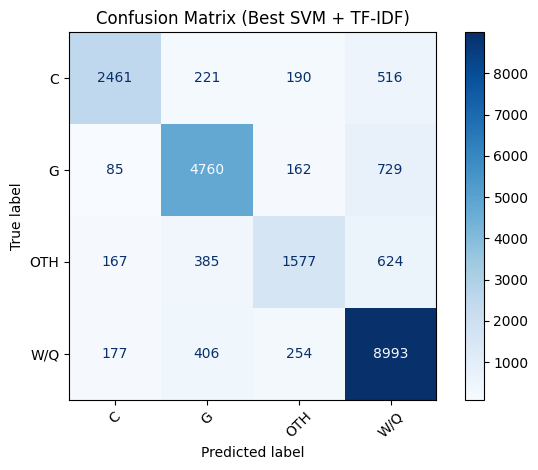


=== ROC AUCs (Best Model) ===
C: AUC = 0.9644
G: AUC = 0.9638
OTH: AUC = 0.9226
W/Q: AUC = 0.9570
Micro-average AUC: 0.9608
Macro-average AUC: 0.9520


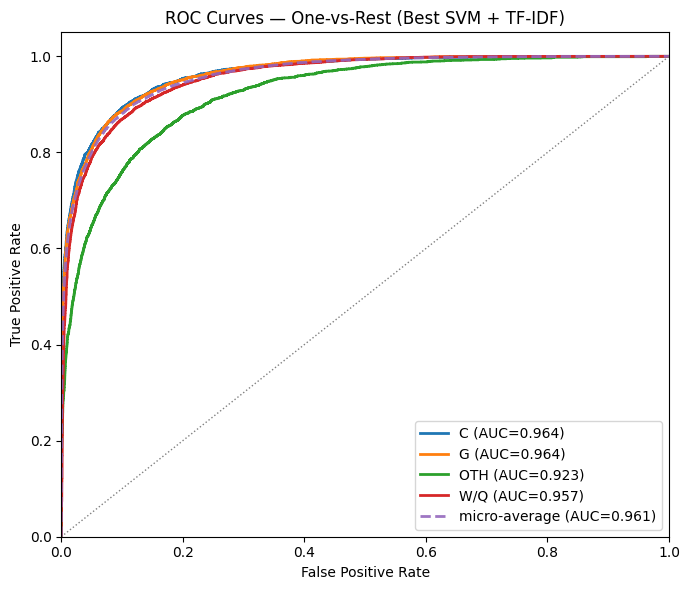

In [ ]:
# Evaluate the best model
# Probabilities for ROC/AUC
if hasattr(best_pipeline.named_steps["clf"], "predict_proba"):
    probs_all = best_pipeline.predict_proba(X_val)
else:
    # Fallback: decision_function -> softmax to pseudo-probs
    scores = best_pipeline.decision_function(X_val)
    if scores.ndim == 1:
        scores = np.vstack([-scores, scores]).T
    exp = np.exp(scores - scores.max(axis=1, keepdims=True))
    probs_all = exp / exp.sum(axis=1, keepdims=True)

# Hard predictions
y_pred = probs_all.argmax(axis=1)

print("\n=== Classification Report (Best Model) ===")
all_labels = list(range(len(le.classes_)))
target_names = [id2label[i] for i in all_labels]
print(classification_report(
    y_val, y_pred,
    labels=all_labels,
    target_names=target_names,
    zero_division=0
))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred, labels=all_labels)
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (Best SVM + TF-IDF)")
plt.tight_layout()
plt.show()

# === ROC / AUC (one-vs-rest) for best model ===
Y_bin = label_binarize(y_val, classes=all_labels)
fprs, tprs, aucs = {}, {}, {}
for i, cls_id in enumerate(all_labels):
    if Y_bin[:, i].sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(Y_bin[:, i], probs_all[:, i])
    fprs[cls_id], tprs[cls_id] = fpr, tpr
    aucs[cls_id] = auc(fpr, tpr)

# Micro / macro AUC
fpr_micro, tpr_micro, _ = roc_curve(Y_bin.ravel(), probs_all.ravel())
auc_micro = auc(fpr_micro, tpr_micro)
auc_macro = float(np.mean(list(aucs.values()))) if aucs else float("nan")

print("\n=== ROC AUCs (Best Model) ===")
for cls_id in all_labels:
    name = id2label[cls_id]
    print(f"{name}: AUC = {aucs[cls_id]:.4f}" if cls_id in aucs else f"{name}: AUC = N/A")
print(f"Micro-average AUC: {auc_micro:.4f}")
print(f"Macro-average AUC: {auc_macro:.4f}")

plt.figure(figsize=(7, 6))
for cls_id in all_labels:
    if cls_id in fprs:
        plt.plot(fprs[cls_id], tprs[cls_id], lw=2, label=f"{id2label[cls_id]} (AUC={aucs[cls_id]:.3f})")
plt.plot(fpr_micro, tpr_micro, lw=2, linestyle="--", label=f"micro-average (AUC={auc_micro:.3f})", alpha=0.9)
plt.plot([0,1],[0,1], color="gray", lw=1, linestyle=":")
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves — One-vs-Rest (Best SVM + TF-IDF)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()